# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.065069,True,7.246121
1,-0.262273,True,5.443472
2,-1.822224,False,-3.271637
3,-1.364950,True,2.124164
4,-2.021841,False,-2.010787
...,...,...,...
995,-1.568119,False,-1.326426
996,1.031200,True,7.580836
997,-0.226644,True,5.539193
998,-2.300363,False,-2.969549


<Axes: xlabel='v0'>

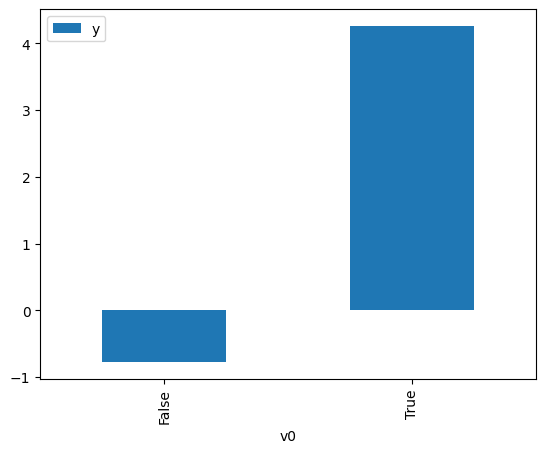

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

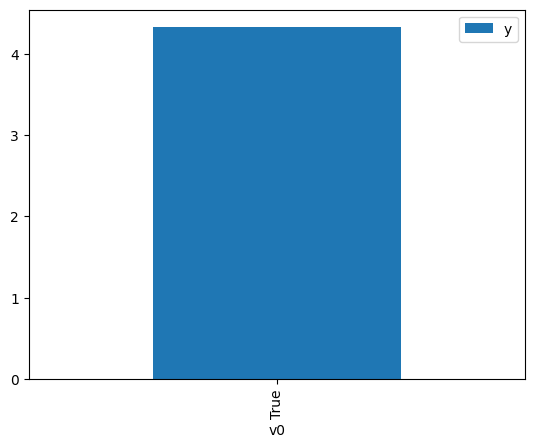

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.428199,False,-0.848334,0.593672,1.684432
1,-1.477214,False,-1.250018,0.829076,1.206163
2,-1.642113,False,-1.901263,0.854173,1.170723
3,-0.526263,False,-1.305132,0.620421,1.611808
4,-0.259714,False,-1.872567,0.546476,1.829906
...,...,...,...,...,...
995,-2.195415,False,-1.800015,0.916874,1.090663
996,-0.376351,False,0.213817,0.579290,1.726251
997,-2.011811,False,-0.606252,0.899402,1.111850
998,-2.384784,False,-2.746509,0.931962,1.073005


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.322957,True,4.398594,0.435663,2.295353
1,-2.210699,True,2.822974,0.081803,12.224434
2,-0.492647,True,5.196297,0.388675,2.572843
3,0.127491,True,5.745793,0.563767,1.773782
4,-0.716163,True,4.849278,0.329918,3.031057
...,...,...,...,...,...
995,-1.420288,True,3.906401,0.180351,5.544758
996,-2.582662,True,2.056397,0.055015,18.176908
997,-0.728376,True,2.970741,0.326837,3.059630
998,-1.648046,True,2.462537,0.144984,6.897316


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              5929.
Date:                Tue, 21 Nov 2023   Prob (F-statistic):                        0.00
Time:                        16:02:18   Log-Likelihood:                         -1411.8
No. Observations:                1000   AIC:                                      2828.
Df Residuals:                     998   BIC:                                      2837.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3254      0.027     49.814      0.000       1.273       1.378
x2             4.9813      0.051     98.059      0.000       4.882       5.081
==============================================================================
Omnibus:                        0.642   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.725   Jarque-Bera (JB):                0.686
Skew:                           0.060   Prob(JB):                        0.710
Kurtosis:                       2.953   Cond. No.                         1.91
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""